In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

# Entrenamiento de modelos de prueba
from sklearn.linear_model import LinearRegression

# Evaluación de modelos de prueba
from sklearn.metrics import roc_auc_score
from sklearn.metrics import mean_squared_error

# Partición de train-test set
from sklearn.model_selection import train_test_split

# Crear datasets
from sklearn.datasets import make_regression

Vamos a crear un dataset sintetico utilizando las librerias de [Sklearn Datasets](https://scikit-learn.org/stable/modules/generated/sklearn.datasets.make_regression.html), en particular nos interesa crear un problema de regresion
lineal al que podemos variarle sus parametros

In [2]:
# Creamos un dataset de prueba
X, y = make_regression(n_samples = 1000,
                       n_features = 1,
                       noise = 2,
                       n_informative = 1,
                       random_state = 42)

new_data = np.append(X,y.reshape(-1,1),axis=1)
new_data.shape

(1000, 2)

In [3]:
df = pd.DataFrame(new_data)

new_col = []
i = 0
for col in df.columns:
    if i ==  len(df.columns) - 1:
        new_col.append("target")
    else :
        new_col.append("feature_" + str(i+1))
        
    i += 1
    
df.columns = new_col

df.head()

,feature_1,target
0,-1.758739,-30.118736
1,1.031845,14.526197
2,-0.487606,-10.119305
3,0.186454,1.700188
4,0.725767,12.345314


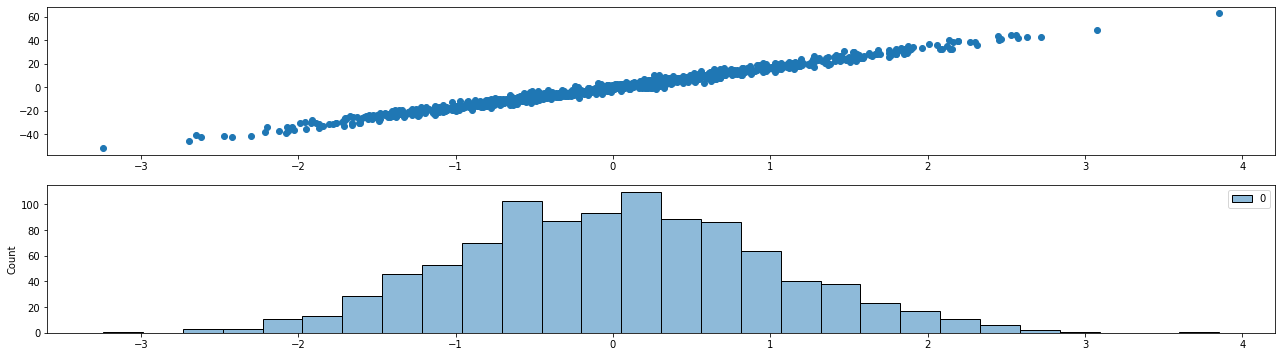

In [4]:
fig,axes = plt.subplots(2,figsize=(22,6))
axes[0].scatter(X,y)
sns.histplot(X, ax=axes[1]);

## Funciones auxiliares para generar datos anómalos

In [6]:
def generate_nulls(df: pd.DataFrame,
                   cols: list = None,
                   percentage: float = 0.05) -> pd.DataFrame:
  """Con esta función vamos a poder generar nulos en ciertas columnas de nuestro
  dataset.
  """  
  cols = df.columns.tolist() if cols is None else cols
  seeds = np.random.randint(100, size = len(cols))
  
  nsamples = np.math.floor(len(df) * percentage)

  result = df.copy(deep = True)
  for i,col_name in enumerate(cols):
      np.random.seed(seeds[i])
      
      idx_to_remove = result[col_name].sample(n = nsamples).index
      result[col_name].iloc[idx_to_remove] = np.nan if result[col_name].dtype in [int,float] else None
  
  return result

def generate_outliers(df: pd.DataFrame,
                     cols: list = None,
                     extreme_outlier: bool = False,
                     two_tailed: bool = False,
                     percentage: float = 0.02) -> pd.DataFrame:
  """Con esta función vamos a poder generar outliers en ciertas columnas de nuestro
  dataset. Si le damos True a _extreme_outlier_ va a generar outliers con mucho
  peso en la regresión (puede ser bilateral o unilateral segun _two_tailed_)
  """  
  seeds = np.random.randint(100, size = len(df))
  
  nsamples = np.math.floor(len(df) * percentage)
  idx_to_change = df.sample(n = nsamples).index

  cols = df.columns.tolist() if cols is None else cols

  result = df.copy(deep = True)
  
  for i,col_name in enumerate(cols):
    np.random.seed(seeds[i])

    iqr = result[col_name].quantile(0.75) - result[col_name].quantile(0.25)

    lb = result[col_name].quantile(0.25) - 1 * iqr
    ub = result[col_name].quantile(0.75) + 1 * iqr

    if two_tailed:
      outs = result[col_name].loc[(result[col_name] < lb) | (result[col_name] > ub)]
    else:
      outs = result[col_name].loc[(result[col_name] > ub)]
    
    out_size = len(outs)
    if out_size < nsamples:
      nsamples = out_size

    idx_to_change = outs.sample(nsamples, replace = False).index
    
    if extreme_outlier:
      outlier_sign = [1 if np.random.random() < 0.9 else -1 for _ in range(nsamples)]
      
      result[col_name].loc[idx_to_change] = np.multiply(outlier_sign,
                                                        np.random.uniform(low = result[col_name].mean(),
                                                                          high = result[col_name].max()*5,
                                                                          size = nsamples)
                                                        )
      result['target'].loc[idx_to_change] = np.multiply(outlier_sign,
                                                        np.random.uniform(low = result['target'].mean(),
                                                                          high = result['target'].max()*2,
                                                                          size = nsamples)
                                                        )
    else:
      samples = result[col_name].loc[idx_to_change].values
      np.random.shuffle(samples)
      result[col_name].loc[idx_to_change] = samples
  
  return result

In [7]:
df_outlier = generate_outliers(df,['feature_1'], percentage = 0.05, extreme_outlier = True, two_tailed= True)

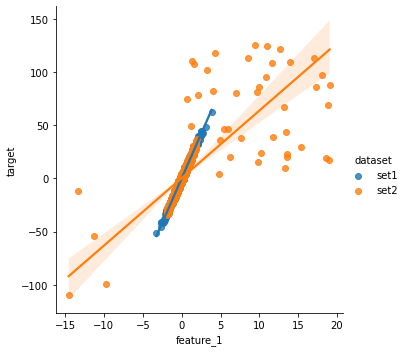

In [8]:
sns.lmplot(data = pd.concat([df.assign(dataset = 'set1'),
                                 df_outlier.assign(dataset = 'set2')]),
                x = 'feature_1',
                y = 'target',
                hue = 'dataset')

In [ ]:
columnas_a_modificar = ['feature_1'] 
df_missing = generate_nulls(df,columnas_a_modificar, percentage = 0.01)

In [ ]:
df_missing.isna().sum()

# Ejercicio 1

Crear una función que separe los datos en train-validation-test 70-20-10


Hints: 

* Usar Indexing y slicing
* Usar np.random.[...]

In [ ]:
def split(df: pd.DataFrame, train_size: float):

    return X_train, X_val, X_test, Y_train, Y_val, Y_test

# Ejercicio 2

Utilizando la funcion `generate_nulls`. Insertar en la columna de features un 5% de valores nulos. Con esto, generar una función que les permita rellenar estos valores con la mediana, y otro con la media.

Compare los __scores__ obtenidos en las regresiones cuando tiene el dataset completo, y con los dos métodos de imputación. ¿Cambian mucho?

In [9]:
df.feature_1.median()

0.025300612234888248

In [ ]:
def mean_imputer(df: pd.DataFrame, columns: str) -> pd.DataFrame:
    pass
    

In [ ]:
def median_imputer(df: pd.DataFrame, columns: str) -> pd.DataFrame:
    pass
    

# Ejercicio 3

Los resultados del ejercicio 1 ¿Cómo se ven afectados cuando empezamos a a tener muchos más valores imputados? Pruebe con distintos porcentajes.

# Ejercicio 4

Utilizando la funcion `generate_outliers` generar puntos extremos dentro de los datos que generamos anteriormente. En este ejercicio dejar setteado `extreme_outliers` como `False` y observe como variando el porcentaje de los mismos la regresión comienza a afectarse.

# Ejercicio 5

Generar ahora valores extremos utilizando `extreme_outliers`. ¿Cómo afecta esto a la regresión? ¿Se observa algo interesante?


# Ejercicio 6

utilizando el archivo CSV `clase3v2.csv`, vamos a cargarlo como dataframe y deberemos:
 - Generar splits de training/test
 - Limpiar/Imputar datos Nulos
 - Entrenar un modelo de regresión simple
 - Reportar $R^2$ en test.

In [ ]:
data_happiness = pd.read_csv('clase3v2.csv', delimiter = ';')

# Ejercicio 6

Por último, manteniendo un dataset limpio como el que generamos previo al ejercio 1, utilizando `make_regression` de `scikit-learn`. Analizar que pasa si comenzamos a modificar el parametro `noise`